# Basic Differentiable Least Squares

In this tutorial we develop a declarative node for solving the ordinary least squares problem,

$$
    \text{minimize} \quad \|Ax - b\|_2^2
$$

parameterized by $m$-by-$n$ matrix $A$ and $m$-vector $b$. The output has closed-form solution

$$
\begin{align*}
    x^\star &= \left(A^T \! A\right)^{-1} \! A^T b \\
    &= R^{-1} Q^{T} b
\end{align*}
$$

where $A = QR$ is the QR decomposition of $A$.

In [1]:
import torch
print(torch.__version__)

torch.manual_seed(22)

import sys
sys.path.append("../")

1.13.0


### Automatic Differentiation

Since QR decomposition is differentiable we can simply produce a PyTorch function for solving the least-squares problem in the forward pass and allow `autograd` to automatically compute gradients in the backward pass.

In [2]:
def solve_by_qr(A, b):
    """Auto-differentiable solver for least squares by QR."""
    B, M, N = A.shape
    assert b.shape == (B, M, 1)

    Q, R = torch.linalg.qr(A, mode='reduced')
    return torch.linalg.solve_triangular(R, torch.bmm(b.view(B, 1, M), Q).view(B, N, 1), upper=True)

Indeed the PyTorch `torch.linalg.lstsq` function is itself auto differentiable.

### Custom Backward Pass

We can develop a more efficient backward pass code by hand deriving the gradients.

Consider differentiating $x^\star$ with respect to single element $A_{ij}$, we have

$$
\begin{align*}
	\frac{\text{d}}{\text{d} A_{ij}} x^\star 
	&= \frac{\text{d}}{\text{d} A_{ij}} \left(A^T \! A\right)^{-1} \! A^T b \\
	&= \left(\frac{\text{d}}{\text{d} A_{ij}} \left(A^T \! A\right)^{-1} \right) A^T b + \left(A^T \! A\right)^{-1} \! \left(\frac{\text{d}}{\text{d} A_{ij}}  A^T b\right)
\end{align*}
$$

Now using the identity $\frac{\text{d}}{\text{d} z} Z^{-1} = -Z^{-1} \left(\frac{\text{d}}{\text{d} z} Z\right) Z^{-1}$ we get, for the first term,

$$
\begin{align*}
	\frac{\text{d}}{\text{d} A_{ij}} \left(A^T \! A\right)^{-1} 
	&= -\left(A^T \! A\right)^{-1} \!\left(\frac{\text{d}}{\text{d} A_{ij}} \left(A^T \! A\right) \right) \left(A^T \! A\right)^{-1} \\
	&= -\left(A^T \! A\right)^{-1} \!\left(E_{ij}^T A + A^T E_{ij}\right) \left(A^T \! A\right)^{-1}
\end{align*}
$$

where $E_{ij}$ is a matrix with one in the $(i,j)$-th element and zeros elsewhere. Furthermore, for the second term,

$$
\begin{align}
	\frac{\text{d}}{\text{d} A_{ij}} A^T b &= E_{ij}^T b
\end{align}
$$


Plugging these back into parent equation we have

$$
\begin{align*}
	\frac{\text{d}}{\text{d} A_{ij}} x^\star 
	&= -\left(A^T \! A\right)^{-1} \!\left(E_{ij}^T A + A^T E_{ij}\right) \left(A^T \! A\right)^{-1} \! A^T b + \left(A^T \! A\right)^{-1} b_i e_j
	\\
	&= -\left(A^T \! A\right)^{-1} \!\left(E_{ij^T} A + A^T E_{ij}\right) x^\star + \left(A^T \! A\right)^{-1} E_{ji} b
	\\
	&= -\left(A^T \! A\right)^{-1} \left( E_{ij}^T (Ax^\star - b) + A^T E_{ij} x^\star \right)
	\\
	&= -\left(A^T \! A\right)^{-1} \left( (a_i^T x^\star - b_i) e_j + x_j^\star a_i \right)
\end{align*}
$$

where $e_j = (0, 0, \ldots, 1, 0, \ldots) \in \mathbb{R}^n$ is the $j$-th canonical vector, i.e., vector with a one in the $j$-th component and zeros everywhere else, and $a_i^T \in \mathbb{R}^{1 \times n}$ is the $i$-th row of matrix $A$.

Observe that the term $(A^TA)^{-1}$ appears both in the solution for $x$ and the derivatives with respect to each $A_{ij}$. Thus, we only need to factor $A$ once in the forward pass and cache $R$ for use during the backward pass. This saves significant compute. Moreover, we can reuse terms for different $\frac{\text{d}}{\text{d} A_{ij}}$ and efficiently combine with the incoming gradient of the loss with respect to $x^\star$ as we now show.

Let $r = b - Ax^\star$ and let $v^T$ denote the backward coming gradient $\frac{\text{d}}{\text{d} x^\star} L$. Then

$$
\begin{align*}
	\frac{\text{d} L}{\text{d} A_{ij}} &= v^T \frac{\text{d} x^\star}{\text{d} A_{ij}} \\
	&= v^T \left(A^T \! A\right)^{-1} \left( r_i e_j - x_j^\star a_i \right) \\
	&= w^T \! \left( r_i e_j - x_j^\star a_i \right) \\
	&= r_i w_j - w^T \! a_i x_j^\star
\end{align*}
$$

where $w = \left(A^T \! A\right)^{-1}v$ does not depend on which $A_{ij}$ we are differentiating with respect to. We can therefore compute the entire matrix of $m \times n$ derivatives efficiently as the sum of outer products

$$
\begin{align*}
	\left(\frac{\text{d} L}{\text{d} A}\right)^{\! T} = \begin{bmatrix}
		\displaystyle \frac{\text{d} L}{\text{d} A_{ij}}
	\end{bmatrix}_{\substack{i=1, \ldots, m \\ j=1, \ldots, n}} &= wr^T + x^\star(Aw)^T
\end{align*}
$$

We can also differentiate with respect to $b$, which is much simpler,

$$
\begin{align*}
	\left(\frac{\text{d} L}{\text{d} b}\right)^{\! T} = Aw
\end{align*}
$$

The following code implement a PyTorch function with hand-coded backward pass. It is also available as ``BasicLeastSquaresFcn`` in the ``ddn.pytorch.leastsquares`` module.

In [3]:
class BasicLeastSquaresFcn(torch.autograd.Function):
    """
    PyTorch autograd function for basic least squares problems,

        y = argmin_u \|Au - b\|

    solved via QR decomposition.
    """

    @staticmethod
    def forward(ctx, A, b, cache_decomposition=True):
        B, M, N = A.shape
        assert b.shape == (B, M, 1)

        with torch.no_grad():
            Q, R = torch.linalg.qr(A, mode='reduced')
            x = torch.linalg.solve_triangular(R, torch.bmm(b.view(B, 1, M), Q).view(B, N, 1), upper=True)

        # save state for backward pass
        ctx.save_for_backward(A, b, x, R if cache_decomposition else None)

        # return solution
        return x

    @staticmethod
    def backward(ctx, dx):
        # check for None tensors
        if dx is None:
            return None, None

        # unpack cached tensors
        A, b, x, R = ctx.saved_tensors
        B, M, N = A.shape

        if R is None:
            Q, R = torch.linalg.qr(A, mode='reduced')

        dA, db = None, None

        w = torch.linalg.solve_triangular(R, torch.linalg.solve_triangular(torch.transpose(R, 2, 1), dx, upper=False), upper=True)
        Aw = torch.bmm(A, w)

        if ctx.needs_input_grad[0]:
            r = b - torch.bmm(A, x)
            dA = torch.einsum("bi,bj->bij", r.view(B, M), w.view(B, N)) - torch.einsum("bi,bj->bij", Aw.view(B, M), x.view(B, N))
        if ctx.needs_input_grad[1]:
            db = Aw

        # return gradients (None for non-tensor inputs)
        return dA, db, None

### Profiling

We profile the running time and memory required by the various implementations. Our test is to solve the bi-level optimisation problem,

$$
\begin{align*}
	\begin{array}{ll}
		\text{minimize} & \frac{1}{2} \|x^\star - x^{\text{target}}\|_2^2 \\
		\text{subject to} & x^\star = \textrm{argmin}_{x} \; \|Ax - b\|_2^2
	\end{array}
\end{align*}
$$

by gradient descent for a fixed number of iterations.

In [4]:
import time
import torch.autograd.profiler as profiler

def do_profile(fcn, B, M, N, device='cpu', seed=0, iters=1000, mem_iters=10):
    """
    Profile implementation. Uses different number of itertions for memory profile
    and speed profiling since memory profiling is slow.
    """

    torch.manual_seed(seed)

    A_true = torch.randn((B, M, N), dtype=torch.double, device=device, requires_grad=False)
    b_true = torch.randn((B, M, 1), dtype=torch.double, device=device, requires_grad=False)
    x_true = torch.linalg.lstsq(A_true, b_true, driver='gels').solution
    A_init = torch.randn((B, M, N), dtype=torch.double, device=device, requires_grad=True)

    # profile time
    model = [torch.nn.Parameter(A_init.clone())]
    optimizer = torch.optim.SGD(model, lr=1.0)
    loss_trace = [None for i in range(iters)]

    time_start = time.monotonic()
    for i in range(len(loss_trace)):
        x = fcn(model[0], b_true)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(x, x_true)
        loss_trace[i] = loss.item()
        loss.backward()
        optimizer.step()

    duration = time.monotonic() - time_start

    # profile memory
    model = [torch.nn.Parameter(A_init.clone())]
    optimizer = torch.optim.SGD(model, lr=1.0)

    with profiler.profile(profile_memory=True) as prof:
        for i in range(mem_iters):
            x = fcn(model[0], b_true)

            optimizer.zero_grad()
            loss = torch.nn.functional.mse_loss(x, x_true)
            loss.backward()
            optimizer.step()

    memory = prof.total_average().cpu_memory_usage
    prof.enabled = False
    
    return duration, memory, loss_trace

...running on size 20-by-10
...running on size 40-by-20
...running on size 60-by-30
...running on size 80-by-40
...running on size 100-by-50
...running on size 150-by-75
...running on size 200-by-100
...running on size 300-by-150
...running on size 400-by-200
time: [0.4840000000112923, 0.5789999999979045, 0.875, 1.1089999999967404, 1.437999999994645, 2.687999999994645, 4.0, 10.26600000000326, 19.968999999997322]
 mem: [666314, 2595147, 5627367, 9950240, 15395990, 34712146, 61703190, 138635132, 246278096]
loss: [4.273053183933686e-07, 0.0009477817191176347, 0.004781967255560915, 0.00508996115485338, 0.011542282491346659, 0.008446672811568159, 0.010942512150971426, 0.009333908353073527, 0.005877548494312296]
time: [0.4539999999979045, 0.5, 0.5149999999994179, 0.6100000000005821, 0.7189999999973224, 1.1560000000026776, 1.4060000000026776, 2.562000000005355, 4.562000000005355]
 mem: [233400, 944288, 2269640, 4063520, 6184592, 14326096, 25905704, 56935592, 101013784]
loss: [4.27305318393308

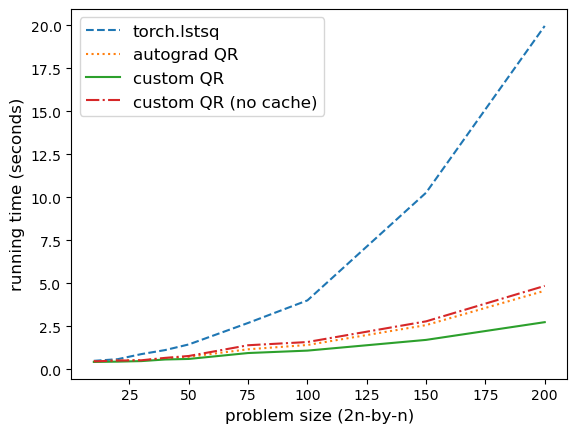

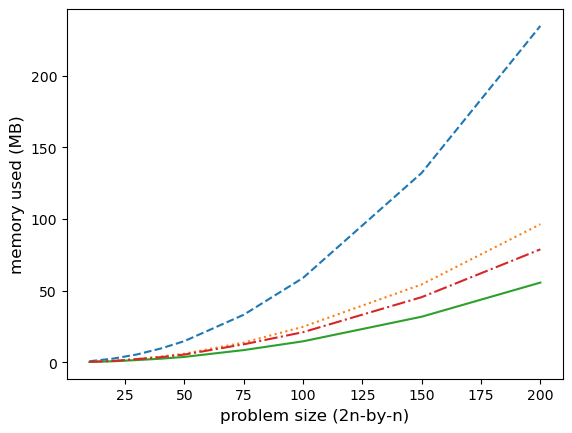

In [5]:
# implementations to test
f_array = [
    lambda A, b: torch.linalg.lstsq(A, b, driver='gels').solution,  # auto-diff torch least-squares solver
    solve_by_qr,                                                    # auto-diff solve by QR decomposition
    BasicLeastSquaresFcn.apply,                                     # custom diff cache QR decomposition
    lambda A, b: BasicLeastSquaresFcn.apply(A, b, False)            # custom diff recompute QR decomposition
]

runtime = [[] for i in range(len(f_array))]
memused = [[] for i in range(len(f_array))]
endloss = [[] for i in range(len(f_array))]

N_array = [10, 20, 30, 40, 50, 75, 100, 150, 200]

for N in N_array:
    print("...running on size {}-by-{}".format(2*N, N))
    for i in range(len(f_array)):
        t, m, loss = do_profile(f_array[i], 1, 2 * N, N)
        runtime[i].append(t)
        memused[i].append(m)
        endloss[i].append(loss[-1])


for i in range(len(f_array)):
    print("time: {}\n mem: {}\nloss: {}".format(runtime[i], memused[i], endloss[i]))

import matplotlib.pyplot as plt

plt.figure()
styles = ['--', ':', '-', '-.']
for i in range(len(f_array)):
    plt.plot(N_array, runtime[i], linestyle=styles[i])
    plt.xlabel('problem size (2n-by-n)', fontsize=12)
    plt.ylabel('running time (seconds)', fontsize=12)
    plt.legend(['torch.lstsq', 'autograd QR', 'custom QR', 'custom QR (no cache)'], fontsize=12)
#plt.savefig("ls_runtime_{}.png".format(device), dpi=300, bbox_inches='tight')

plt.figure()
for i in range(len(f_array)):
    plt.plot(N_array, [m  / (1024 * 1024) for m in memused[i]], linestyle=styles[i])
    plt.xlabel('problem size (2n-by-n)', fontsize=12)
    plt.ylabel('memory used (MB)', fontsize=12)
#plt.savefig("ls_memory_{}.png"..format(device), dpi=300, bbox_inches='tight')

plt.show()